<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Copy_of_Yet_another_copy_of_Hybrid_pmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 20.3 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# === X_scaled, y_combined must be defined from your preprocessing ===
# X_scaled → shape (n_samples, 6)
# y_combined → shape (n_samples, 3) [log10(Id), gm_scaled, gd_scaled]

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

# === Optuna Objective Function ===
def objective(trial):
    # Loss term weights to tune
    w_Id   = trial.suggest_float("w_Id", 2.0, 6.0)
    w_gm   = trial.suggest_float("w_gm", 1.0, 4.0)
    w_gd   = trial.suggest_float("w_gd", 0.5, 2.0)
    w_gm_s = trial.suggest_float("w_gm_smooth", 0.001, 0.05)
    w_gd_s = trial.suggest_float("w_gd_smooth", 0.001, 0.05)
    w_gm_2 = trial.suggest_float("w_gm_second", 0.0001, 0.01)
    w_gd_2 = trial.suggest_float("w_gd_second", 0.0001, 0.01)

    # Define loss function with trial weights
    def hybrid_loss_opt(y_true, y_pred):
        log_Id_true = y_true[:, 0]
        gm_true     = y_true[:, 1]
        gd_true     = y_true[:, 2]

        log_Id_pred = y_pred[:, 0]
        gm_pred     = y_pred[:, 1]
        gd_pred     = y_pred[:, 2]

        loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
        loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
        loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

        gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
        gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

        gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
        gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

        return (
            w_Id * loss_Id +
            w_gm * loss_gm +
            w_gd * loss_gd +
            w_gm_s * gm_smooth +
            w_gd_s * gd_smooth +
            w_gm_2 * gm_second +
            w_gd_2 * gd_second
        )

    # Define model
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(3)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss_opt)

    # Fit model
    model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate validation I_ds MSE
    y_val_pred = model.predict(X_val_opt)
    log_Id_true = y_val_opt[:, 0]
    log_Id_pred = y_val_pred[:, 0]
    Id_true = 10 ** log_Id_true
    Id_pred = 10 ** log_Id_pred

    return mean_squared_error(Id_true, Id_pred)

# === Run Optuna Study ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# === Print Best Parameters ===
print("\nBest loss weights found:")
for key, val in study.best_params.items():
    print(f"{key}: {val:.4f}")


[I 2025-05-09 16:45:25,270] A new study created in memory with name: no-name-bb9b455c-ba27-4b0b-8588-4eca6f89fa6a


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-09 16:46:03,388] Trial 0 finished with value: 1.284293655411943e-10 and parameters: {'w_Id': 2.525108474635792, 'w_gm': 2.61870608267413, 'w_gd': 0.9552660127757965, 'w_gm_smooth': 0.02637151617074354, 'w_gd_smooth': 0.010370954638079976, 'w_gm_second': 0.008410063504682626, 'w_gd_second': 0.007545490410725906}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:46:31,632] Trial 1 finished with value: 2.328867075043509e-10 and parameters: {'w_Id': 5.74099868178114, 'w_gm': 1.6641366078491098, 'w_gd': 1.3376589533527865, 'w_gm_smooth': 0.03128062067905941, 'w_gd_smooth': 0.026971809292195507, 'w_gm_second': 0.008131869342449813, 'w_gd_second': 0.009763331966929547}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:04,126] Trial 2 finished with value: 2.1503969397893068e-10 and parameters: {'w_Id': 5.210864068713551, 'w_gm': 2.4567804855131286, 'w_gd': 1.4570894550492506, 'w_gm_smooth': 0.015235584068062104, 'w_gd_smooth': 0.047709953337632754, 'w_gm_second': 0.0002882898628717637, 'w_gd_second': 0.0037377452557540505}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:41,723] Trial 3 finished with value: 1.0970864292143141e-10 and parameters: {'w_Id': 2.5733139820865008, 'w_gm': 1.5636681338427767, 'w_gd': 1.2837947620985761, 'w_gm_smooth': 0.005339624499626156, 'w_gd_smooth': 0.03588261398845419, 'w_gm_second': 0.008090132286054482, 'w_gd_second': 0.0027249730445105293}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:07,795] Trial 4 finished with value: 4.449782141917571e-10 and parameters: {'w_Id': 5.714855843363008, 'w_gm': 1.431664774275986, 'w_gd': 0.8419695687128987, 'w_gm_smooth': 0.03766535518833621, 'w_gd_smooth': 0.0035263095019293887, 'w_gm_second': 0.0023090336595153857, 'w_gd_second': 0.001858558893205015}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:40,377] Trial 5 finished with value: 1.9872607084867326e-10 and parameters: {'w_Id': 4.921425905914983, 'w_gm': 3.210657016217744, 'w_gd': 1.182327338128778, 'w_gm_smooth': 0.048168578202739336, 'w_gd_smooth': 0.03648288624323011, 'w_gm_second': 0.0036606441085774615, 'w_gd_second': 0.009980825819554869}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:10,124] Trial 6 finished with value: 4.3163468879461184e-08 and parameters: {'w_Id': 2.6119603015713793, 'w_gm': 3.143202737796021, 'w_gd': 1.6282002708977306, 'w_gm_smooth': 0.0347554569935443, 'w_gd_smooth': 0.04850628519757475, 'w_gm_second': 0.0033917804592477154, 'w_gd_second': 0.008725303382350521}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:45,192] Trial 7 finished with value: 1.03582207529973e-10 and parameters: {'w_Id': 4.798155010651325, 'w_gm': 2.581478232440331, 'w_gd': 1.533429675828571, 'w_gm_smooth': 0.019438177938510603, 'w_gd_smooth': 0.02436087124893307, 'w_gm_second': 0.006481188064761129, 'w_gd_second': 0.006438926415808942}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:24,280] Trial 8 finished with value: 2.5170592503726784e-10 and parameters: {'w_Id': 3.3672755645470382, 'w_gm': 1.3935205002788558, 'w_gd': 0.7984867831772668, 'w_gm_smooth': 0.00655070023758318, 'w_gd_smooth': 0.005972494651898182, 'w_gm_second': 0.009701910218783177, 'w_gd_second': 0.006783040237440222}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:55,804] Trial 9 finished with value: 1.5291125097527042e-10 and parameters: {'w_Id': 2.713994495311458, 'w_gm': 1.369562812013406, 'w_gd': 1.7213113875636874, 'w_gm_smooth': 0.0016106568534056754, 'w_gd_smooth': 0.0029816978848805293, 'w_gm_second': 0.001983758631221469, 'w_gd_second': 0.008874857649013473}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:51:34,835] Trial 10 finished with value: 2.200655060246602e-10 and parameters: {'w_Id': 4.267675136360571, 'w_gm': 3.8803499597771416, 'w_gd': 1.9951740718700375, 'w_gm_smooth': 0.017203356740203297, 'w_gd_smooth': 0.017520068925201412, 'w_gm_second': 0.006172460192624349, 'w_gd_second': 0.00023713378126987653}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:08,235] Trial 11 finished with value: 1.4010636798723745e-10 and parameters: {'w_Id': 3.952808633760487, 'w_gm': 2.0497269387903403, 'w_gd': 0.5425675521242903, 'w_gm_smooth': 0.014800340166855237, 'w_gd_smooth': 0.030926808782296783, 'w_gm_second': 0.006156881291788535, 'w_gd_second': 0.004686671716369662}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:40,615] Trial 12 finished with value: 1.996460857200093e-10 and parameters: {'w_Id': 2.0490503953758172, 'w_gm': 2.053465014421755, 'w_gd': 1.103878728261562, 'w_gm_smooth': 0.009363626970260178, 'w_gd_smooth': 0.03521050956991325, 'w_gm_second': 0.00692600052805965, 'w_gd_second': 0.003157232775888227}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:13,836] Trial 13 finished with value: 3.205469888577667e-10 and parameters: {'w_Id': 4.338522253476978, 'w_gm': 1.0167385097682766, 'w_gd': 1.5416690570383245, 'w_gm_smooth': 0.02261238507546403, 'w_gd_smooth': 0.016653917557890488, 'w_gm_second': 0.004636166150313364, 'w_gd_second': 0.00596532597501202}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:47,181] Trial 14 finished with value: 2.2621477020709267e-10 and parameters: {'w_Id': 3.5495004946985196, 'w_gm': 2.795423647141415, 'w_gd': 1.8180039416638083, 'w_gm_smooth': 0.00789589257072473, 'w_gd_smooth': 0.041233699286558956, 'w_gm_second': 0.007841099243133923, 'w_gd_second': 0.002142098051867045}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:18,351] Trial 15 finished with value: 1.638469930332012e-10 and parameters: {'w_Id': 4.912558497325177, 'w_gm': 2.072246119297343, 'w_gd': 1.354085113711194, 'w_gm_smooth': 0.02150387679162183, 'w_gd_smooth': 0.02159639939201472, 'w_gm_second': 0.009983171433189891, 'w_gd_second': 0.005186192515932755}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:52,089] Trial 16 finished with value: 1.0248681925654913e-10 and parameters: {'w_Id': 3.2088941303854384, 'w_gm': 3.6969661426950857, 'w_gd': 1.0623633314871652, 'w_gm_smooth': 0.002148469175921847, 'w_gd_smooth': 0.026620994954633492, 'w_gm_second': 0.005149324713964281, 'w_gd_second': 0.0001667748119033763}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:55:28,875] Trial 17 finished with value: 1.8407121240854644e-10 and parameters: {'w_Id': 3.297808377921649, 'w_gm': 3.973850946210488, 'w_gd': 0.5735251753508795, 'w_gm_smooth': 0.04353901146375848, 'w_gd_smooth': 0.0248270245874676, 'w_gm_second': 0.005249247843890989, 'w_gd_second': 0.0009394319391177474}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:06,568] Trial 18 finished with value: 9.307551393587296e-11 and parameters: {'w_Id': 3.947713893807383, 'w_gm': 3.580130182558091, 'w_gd': 1.0310470392455926, 'w_gm_smooth': 0.028616939096605933, 'w_gd_smooth': 0.01406579762566183, 'w_gm_second': 0.004505151412378951, 'w_gd_second': 0.004511328276431005}. Best is trial 18 with value: 9.307551393587296e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:45,590] Trial 19 finished with value: 7.255931304594216e-11 and parameters: {'w_Id': 3.7996858459916356, 'w_gm': 3.5916236164965616, 'w_gd': 1.0632788936064497, 'w_gm_smooth': 0.02773364813840763, 'w_gd_smooth': 0.012407471368941067, 'w_gm_second': 0.004404892096928941, 'w_gd_second': 0.004340213566792695}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:21,946] Trial 20 finished with value: 1.184521714307075e-10 and parameters: {'w_Id': 3.884271182735457, 'w_gm': 3.4420896571706683, 'w_gd': 0.7589776364146769, 'w_gm_smooth': 0.027865228701586697, 'w_gd_smooth': 0.011152411360281831, 'w_gm_second': 0.003851359362946332, 'w_gd_second': 0.004372744369261027}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:59,612] Trial 21 finished with value: 1.5588605411720707e-10 and parameters: {'w_Id': 3.11963457694195, 'w_gm': 3.6185477803708155, 'w_gd': 1.0683599502921888, 'w_gm_smooth': 0.030847774100267428, 'w_gd_smooth': 0.015005232477606857, 'w_gm_second': 0.005024020201367263, 'w_gd_second': 0.005309073948684901}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:58:32,791] Trial 22 finished with value: 2.285717577112841e-10 and parameters: {'w_Id': 3.670477457897224, 'w_gm': 3.633328393574852, 'w_gd': 0.9785785349164164, 'w_gm_smooth': 0.03870227989422652, 'w_gd_smooth': 0.01016720667500716, 'w_gm_second': 0.002685640728744839, 'w_gd_second': 0.003637077064017359}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:00,223] Trial 23 finished with value: 3.369380223430565e-10 and parameters: {'w_Id': 4.336927103180093, 'w_gm': 3.4117816453582717, 'w_gd': 0.9564329204388701, 'w_gm_smooth': 0.024703443817555987, 'w_gd_smooth': 0.020122122992244352, 'w_gm_second': 0.004535644865410349, 'w_gd_second': 0.0014688689448707367}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:31,002] Trial 24 finished with value: 4.922811253969567e-10 and parameters: {'w_Id': 3.1073239013725518, 'w_gm': 3.0217776875197555, 'w_gd': 1.1721467857798233, 'w_gm_smooth': 0.03252403899007173, 'w_gd_smooth': 0.029032007779478407, 'w_gm_second': 0.005500112401901968, 'w_gd_second': 0.0004529525783629213}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:04,743] Trial 25 finished with value: 1.8551501090114462e-10 and parameters: {'w_Id': 2.938903657262007, 'w_gm': 3.7026912617958363, 'w_gd': 0.6863577693738838, 'w_gm_smooth': 0.012013372112282752, 'w_gd_smooth': 0.014987155911189048, 'w_gm_second': 0.0011906977606225048, 'w_gd_second': 0.0025952709343939275}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:38,860] Trial 26 finished with value: 2.426662917457488e-10 and parameters: {'w_Id': 3.6971379764751613, 'w_gm': 3.364925948801799, 'w_gd': 1.0656523217886225, 'w_gm_smooth': 0.02877631011014691, 'w_gd_smooth': 0.0077321474916973235, 'w_gm_second': 0.004334878852914713, 'w_gd_second': 0.004189106872757616}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:16,583] Trial 27 finished with value: 3.659958664586927e-10 and parameters: {'w_Id': 4.213119023020789, 'w_gm': 2.9213828409814337, 'w_gd': 1.2124886600346112, 'w_gm_smooth': 0.04133177009670118, 'w_gd_smooth': 0.012951940762991079, 'w_gm_second': 0.003112699458080374, 'w_gd_second': 0.0073716778835000146}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:55,733] Trial 28 finished with value: 9.603513669873365e-11 and parameters: {'w_Id': 4.522009126203086, 'w_gm': 3.7234913488032917, 'w_gd': 0.9648942212348361, 'w_gm_smooth': 0.02359402553546139, 'w_gd_smooth': 0.020933232718399933, 'w_gm_second': 0.007114180710681702, 'w_gd_second': 0.005681471272363093}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:02:24,303] Trial 29 finished with value: 3.6335967144004525e-10 and parameters: {'w_Id': 4.60033953916491, 'w_gm': 3.8560756718881173, 'w_gd': 0.8584955971285357, 'w_gm_smooth': 0.025267183231564655, 'w_gd_smooth': 0.020459404180900028, 'w_gm_second': 0.007309697243629962, 'w_gd_second': 0.005712400499140809}. Best is trial 19 with value: 7.255931304594216e-11.



Best loss weights found:
w_Id: 3.7997
w_gm: 3.5916
w_gd: 1.0633
w_gm_smooth: 0.0277
w_gd_smooth: 0.0124
w_gm_second: 0.0044
w_gd_second: 0.0043


In [42]:

def hybrid_loss(y_true, y_pred):
    log_Id_true = y_true[:, 0]
    gm_true     = y_true[:, 1]
    gd_true     = y_true[:, 2]

    log_Id_pred = y_pred[:, 0]
    gm_pred     = y_pred[:, 1]
    gd_pred     = y_pred[:, 2]

    loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
    log_Id_smooth = tf.reduce_mean(tf.square(log_Id_pred[1:] - log_Id_pred[:-1]))
    log_Id_second = tf.reduce_mean(tf.square(log_Id_pred[2:] - 2 * log_Id_pred[1:-1] + log_Id_pred[:-2]))

    loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
    loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

    gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
    gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

    gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
    gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

    return (
        3.8 * loss_Id +
        3.5916 * loss_gm +
        1.0633 * loss_gd +
        0.0277 * gm_smooth +
        0.0124 * gd_smooth +
        0.0044 * gm_second +
        0.0043 * gd_second

    )

In [43]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
# import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

final_model = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(3)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss)

# Save best model
checkpoint = ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train with validation split
history = final_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=400,
    batch_size=128,
    verbose=1,
    callbacks=[checkpoint]
)



Epoch 1/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 60.5638
Epoch 1: val_loss improved from inf to 14.90821, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 60.0609 - val_loss: 14.9082
Epoch 2/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.6840
Epoch 2: val_loss improved from 14.90821 to 12.29373, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 13.6689 - val_loss: 12.2937
Epoch 3/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.1377
Epoch 3: val_loss improved from 12.29373 to 11.63588, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.1262 - val_loss: 11.6359
Epoch 4/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2894
Epoch 4: val_loss improved from 11.63588 to 10.96842, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.2879 - val_loss: 10.9684
Epoch 5/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.8311
Epoch 5: val_loss improved from 10.96842 to 10.47755, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8278 - val_loss: 10.4775
Epoch 6/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.4900 
Epoch 6: val_loss improved from 10.47755 to 10.17032, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.4218 - val_loss: 10.1703
Epoch 7/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.2947 
Epoch 7: val_loss did not improve from 10.17032
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9365 - val_loss: 10.1947
Epoch 8/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1941  
Epoch 8: val_loss improved from 10.17032 to 8.04449, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.1058 - val_loss: 8.0445
Epoch 9/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5261 
Epoch 9: val_loss improved from 8.04449 to 6.30803, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5186 - val_loss: 6.3080
Epoch 10/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2568 
Epoch 10: val_loss improved from 6.30803 to 4.77554, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0831 - val_loss: 4.7755
Epoch 11/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9527 
Epoch 11: val_loss improved from 4.77554 to 3.96869, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8521 - val_loss: 3.9687
Epoch 12/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9459 
Epoch 12: val_loss improved from 3.96869 to 3.78504, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1312 - val_loss: 3.7850
Epoch 13/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9349 
Epoch 13: val_loss improved from 3.78504 to 3.61396, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9251 - val_loss: 3.6140
Epoch 14/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3568 
Epoch 14: val_loss improved from 3.61396 to 3.25525, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1260 - val_loss: 3.2553
Epoch 15/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4863 
Epoch 15: val_loss improved from 3.25525 to 3.14423, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5279 - val_loss: 3.1442
Epoch 16/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9621
Epoch 16: val_loss improved from 3.14423 to 2.93760, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9685 - val_loss: 2.9376
Epoch 17/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1384 
Epoch 17: val_loss improved from 2.93760 to 2.75161, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1159 - val_loss: 2.7516
Epoch 18/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8643 
Epoch 18: val_loss improved from 2.75161 to 2.56516, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9416 - val_loss: 2.5652
Epoch 19/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7230 
Epoch 19: val_loss improved from 2.56516 to 2.45873, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7776 - val_loss: 2.4587
Epoch 20/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5029
Epoch 20: val_loss improved from 2.45873 to 2.32692, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5048 - val_loss: 2.3269
Epoch 21/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6110 
Epoch 21: val_loss improved from 2.32692 to 2.21240, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5605 - val_loss: 2.2124
Epoch 22/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2985 
Epoch 22: val_loss did not improve from 2.21240
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3486 - val_loss: 2.2255
Epoch 23/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0770 
Epoch 23: val_loss improved from 2.21240 to 2.06326, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1449 - val_loss: 2.0633
Epoch 24/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2908 
Epoch 24: val_loss improved from 2.06326 to 2.03558, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2275 - val_loss: 2.0356
Epoch 25/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0672 
Epoch 25: val_loss improved from 2.03558 to 1.99719, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0670 - val_loss: 1.9972
Epoch 26/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0213 
Epoch 26: val_loss did not improve from 1.99719
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9951 - val_loss: 2.0079
Epoch 27/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7802 
Epoch 27: val_loss improved from 1.99719 to 1.68217, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8317 - val_loss: 1.6822
Epoch 28/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0262 
Epoch 28: val_loss improved from 1.68217 to 1.60229, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8842 - val_loss: 1.6023
Epoch 29/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7153 
Epoch 29: val_loss did not improve from 1.60229
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7021 - val_loss: 2.3122
Epoch 30/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6799 
Epoch 30: val_loss did not improve from 1.60229
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6608 - val_loss: 1.7553
Epoch 31/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5504 
Epoch 31: val_loss improved from 1.60229 to 1.51495, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5476 - val_loss: 1.5149
Epoch 32/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5508 
Epoch 32: val_loss improved from 1.51495 to 1.48074, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5199 - val_loss: 1.4807
Epoch 33/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6423 
Epoch 33: val_loss improved from 1.48074 to 1.22186, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5096 - val_loss: 1.2219
Epoch 34/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2357 
Epoch 34: val_loss did not improve from 1.22186
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2768 - val_loss: 1.3674
Epoch 35/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2185 
Epoch 35: val_loss did not improve from 1.22186
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2133 - val_loss: 1.7675
Epoch 36/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2888 
Epoch 36: val_loss did not improve from 1.22186
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3681 - val_loss: 1.9382
Epoch 37/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4917 
Epoch 37: val_loss did not improve from 1.22186
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4042 - val_loss: 1.8429
Epoch 38/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3679 
Epoch 38: val_loss improved from 1.22186 to 0.91689, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2472 - val_loss: 0.9169
Epoch 39/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9781 
Epoch 39: val_loss did not improve from 0.91689
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0068 - val_loss: 1.8336
Epoch 40/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2280 
Epoch 40: val_loss did not improve from 0.91689
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1278 - val_loss: 0.9511
Epoch 41/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3519 
Epoch 41: val_loss did not improve from 0.91689
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2361 - val_loss: 1.7784
Epoch 42/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5867
Epoch 42: val_loss improved from 0.91689 to 0.91163, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5807 - val_loss: 0.9116
Epoch 43/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7573 
Epoch 43: val_loss improved from 0.91163 to 0.82801, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7780 - val_loss: 0.8280
Epoch 44/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8557 
Epoch 44: val_loss did not improve from 0.82801
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8215 - val_loss: 1.8985
Epoch 45/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5783 
Epoch 45: val_loss did not improve from 0.82801
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3498 - val_loss: 0.9366
Epoch 46/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7613 
Epoch 46: val_loss improved from 0.82801 to 0.70077, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7419 - val_loss: 0.7008
Epoch 47/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6986 
Epoch 47: val_loss improved from 0.70077 to 0.66574, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7170 - val_loss: 0.6657
Epoch 48/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6071 
Epoch 48: val_loss improved from 0.66574 to 0.56871, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6196 - val_loss: 0.5687
Epoch 49/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6426
Epoch 49: val_loss did not improve from 0.56871
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6422 - val_loss: 0.6621
Epoch 50/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6057 
Epoch 50: val_loss did not improve from 0.56871
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6049 - val_loss: 0.6600
Epoch 51/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5640 
Epoch 51: val_loss improved from 0.56871 to 0.46571, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5858 - val_loss: 0.4657
Epoch 52/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4260 
Epoch 52: val_loss did not improve from 0.46571
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4442 - val_loss: 0.5434
Epoch 53/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4922 
Epoch 53: val_loss improved from 0.46571 to 0.44793, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4965 - val_loss: 0.4479
Epoch 54/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3932 
Epoch 54: val_loss improved from 0.44793 to 0.40219, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4217 - val_loss: 0.4022
Epoch 55/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6479
Epoch 55: val_loss did not improve from 0.40219
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6485 - val_loss: 0.4641
Epoch 56/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5268 
Epoch 56: val_loss did not improve from 0.40219
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4909 - val_loss: 0.4117
Epoch 57/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3528
Epoch 57: val_loss did not improve from 0.40219
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3539 - val_loss: 0.4206
Epoch 58/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6896
Epoch 58: val_loss did not improve from 0.40219
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6890 - val_loss: 0.4418
Epoch 59/400
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3500
Epoch 59: val_loss improved from 0.40219 to 0.32634, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3501 - val_loss: 0.3263
Epoch 60/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3563 
Epoch 60: val_loss did not improve from 0.32634
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3661 - val_loss: 0.4184
Epoch 61/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4190 
Epoch 61: val_loss did not improve from 0.32634
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4304 - val_loss: 0.4107
Epoch 62/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3661 
Epoch 62: val_loss improved from 0.32634 to 0.28019, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3410 - val_loss: 0.2802
Epoch 63/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3322 
Epoch 63: val_loss improved from 0.28019 to 0.27771, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3301 - val_loss: 0.2777
Epoch 64/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2909 
Epoch 64: val_loss improved from 0.27771 to 0.27062, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3073 - val_loss: 0.2706
Epoch 65/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3143 
Epoch 65: val_loss did not improve from 0.27062
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3840 - val_loss: 0.7708
Epoch 66/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6085 
Epoch 66: val_loss did not improve from 0.27062
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5485 - val_loss: 0.3076
Epoch 67/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2649 
Epoch 67: val_loss did not improve from 0.27062
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2684 - val_loss: 0.2747
Epoch 68/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2566 
Epoch 68: val_loss did not improve from 0.27062
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2558 - val_loss: 0.3562
Epoch 69/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2492 
Epoch 69: val_loss improved from 0.27062 to 0.24942, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2451 - val_loss: 0.2494
Epoch 70/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2403 
Epoch 70: val_loss did not improve from 0.24942
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2659 - val_loss: 0.3316
Epoch 71/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3488 
Epoch 71: val_loss improved from 0.24942 to 0.23103, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3254 - val_loss: 0.2310
Epoch 72/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2287 
Epoch 72: val_loss did not improve from 0.23103
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2304 - val_loss: 0.2641
Epoch 73/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2318 
Epoch 73: val_loss improved from 0.23103 to 0.21458, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2375 - val_loss: 0.2146
Epoch 74/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2722 
Epoch 74: val_loss did not improve from 0.21458
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3047 - val_loss: 0.2371
Epoch 75/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2658 
Epoch 75: val_loss did not improve from 0.21458
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2552 - val_loss: 0.2580
Epoch 76/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2182 
Epoch 76: val_loss improved from 0.21458 to 0.21243, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2138 - val_loss: 0.2124
Epoch 77/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2108 
Epoch 77: val_loss did not improve from 0.21243
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2190 - val_loss: 0.2454
Epoch 78/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2250 
Epoch 78: val_loss did not improve from 0.21243
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2267 - val_loss: 0.2706
Epoch 79/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2238
Epoch 79: val_loss did not improve from 0.21243
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2233 - val_loss: 0.2320
Epoch 80/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2304 
Epoch 80: val_loss improved from 0.21243 to 0.19249, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2242 - val_loss: 0.1925
Epoch 81/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1779 
Epoch 81: val_loss did not improve from 0.19249
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1921 - val_loss: 0.3218
Epoch 82/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2413 
Epoch 82: val_loss improved from 0.19249 to 0.18431, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2296 - val_loss: 0.1843
Epoch 83/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1953 
Epoch 83: val_loss did not improve from 0.18431
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1989 - val_loss: 0.2976
Epoch 84/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2355 
Epoch 84: val_loss did not improve from 0.18431
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2392 - val_loss: 0.2786
Epoch 85/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2489 
Epoch 85: val_loss did not improve from 0.18431
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2388 - val_loss: 0.2953
Epoch 86/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3368 
Epoch 86: val_loss did not improve from 0.18431
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3188 - val_loss: 0.1869
Epoch 87/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1731
Epoch 87: val_loss did not improve from 0.18431
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1731 - 

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1822 - val_loss: 0.1804
Epoch 94/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1652 
Epoch 94: val_loss did not improve from 0.18041
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1719 - val_loss: 0.1993
Epoch 95/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1871 
Epoch 95: val_loss improved from 0.18041 to 0.18012, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1879 - val_loss: 0.1801
Epoch 96/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1749 
Epoch 96: val_loss improved from 0.18012 to 0.16781, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1740 - val_loss: 0.1678
Epoch 97/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1651 
Epoch 97: val_loss did not improve from 0.16781
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1672 - val_loss: 0.1688
Epoch 98/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1701 
Epoch 98: val_loss did not improve from 0.16781
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1705 - val_loss: 0.2372
Epoch 99/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3246 
Epoch 99: val_loss did not improve from 0.16781
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4943 - val_loss: 2.7131
Epoch 100/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2339 
Epoch 100: val_loss did not improve from 0.16781
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0495 - val_loss: 0.2619
Epoch 101/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3982 
Epoch 101: val_loss did not improve from 0.16781
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.36

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1684 - val_loss: 0.1640
Epoch 104/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1735 
Epoch 104: val_loss did not improve from 0.16402
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1689 - val_loss: 0.1864
Epoch 105/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1818 
Epoch 105: val_loss did not improve from 0.16402
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1757 - val_loss: 0.1653
Epoch 106/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1572 
Epoch 106: val_loss did not improve from 0.16402
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1593 - val_loss: 0.1661
Epoch 107/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1592 
Epoch 107: val_loss improved from 0.16402 to 0.16380, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1619 - val_loss: 0.1638
Epoch 108/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1577 
Epoch 108: val_loss did not improve from 0.16380
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1672 - val_loss: 0.1986
Epoch 109/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1916
Epoch 109: val_loss improved from 0.16380 to 0.16011, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1909 - val_loss: 0.1601
Epoch 110/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1634 
Epoch 110: val_loss did not improve from 0.16011
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1618 - val_loss: 0.1610
Epoch 111/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1722 
Epoch 111: val_loss did not improve from 0.16011
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1677 - val_loss: 0.1610
Epoch 112/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1643
Epoch 112: val_loss did not improve from 0.16011
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1642 - val_loss: 0.1690
Epoch 113/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1645
Epoch 113: val_loss did not improve from 0.16011
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1649 - val_loss: 0.1632
Epoch 114/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1628
Epoch 114: val_loss did not improve from 0.16011
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1739 - val_loss: 0.1582
Epoch 120/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1460 
Epoch 120: val_loss did not improve from 0.15815
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1500 - val_loss: 0.1652
Epoch 121/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1505 
Epoch 121: val_loss improved from 0.15815 to 0.15421, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1521 - val_loss: 0.1542
Epoch 122/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1458 
Epoch 122: val_loss did not improve from 0.15421
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1515 - val_loss: 0.1688
Epoch 123/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1812 
Epoch 123: val_loss did not improve from 0.15421
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1892 - val_loss: 0.2203
Epoch 124/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1912 
Epoch 124: val_loss did not improve from 0.15421
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1822 - val_loss: 0.1833
Epoch 125/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1736 
Epoch 125: val_loss did not improve from 0.15421
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1743 - val_loss: 0.1811
Epoch 126/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1609 
Epoch 126: val_loss did not improve from 0.15421
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1478 - val_loss: 0.1496
Epoch 139/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1650 
Epoch 139: val_loss did not improve from 0.14963
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1606 - val_loss: 0.1764
Epoch 140/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1564 
Epoch 140: val_loss did not improve from 0.14963
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1552 - val_loss: 0.1827
Epoch 141/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2112
Epoch 141: val_loss did not improve from 0.14963
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2111 - val_loss: 0.1595
Epoch 142/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1661
Epoch 142: val_loss did not improve from 0.14963
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1660 - val_loss: 0.1531
Epoch 143/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1524 
Epoch 143: val_loss did not improve from 0.14963
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1510 - val_loss: 0.1496
Epoch 167/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1454
Epoch 167: val_loss improved from 0.14962 to 0.14889, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1454 - val_loss: 0.1489
Epoch 168/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1404 
Epoch 168: val_loss did not improve from 0.14889
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1406 - val_loss: 0.1499
Epoch 169/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1477 
Epoch 169: val_loss did not improve from 0.14889
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1466 - val_loss: 0.1520
Epoch 170/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1329 
Epoch 170: val_loss did not improve from 0.14889
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1382 - val_loss: 0.1545
Epoch 171/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1439 
Epoch 171: val_loss did not improve from 0.14889
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1441 - val_loss: 0.1511
Epoch 172/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1566
Epoch 172: val_loss improved from 0.14889 to 0.14838, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1563 - val_loss: 0.1484
Epoch 173/400
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1570
Epoch 173: val_loss did not improve from 0.14838
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1567 - val_loss: 0.1654
Epoch 174/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1417 
Epoch 174: val_loss did not improve from 0.14838
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1449 - val_loss: 0.1499
Epoch 175/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1489 
Epoch 175: val_loss improved from 0.14838 to 0.14815, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1495 - val_loss: 0.1481
Epoch 176/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1356 
Epoch 176: val_loss did not improve from 0.14815
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1368 - val_loss: 0.1496
Epoch 177/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1486 
Epoch 177: val_loss did not improve from 0.14815
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1484 - val_loss: 0.1504
Epoch 178/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1392 
Epoch 178: val_loss did not improve from 0.14815
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1417 - val_loss: 0.1502
Epoch 179/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1391 
Epoch 179: val_loss did not improve from 0.14815
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1393 - val_loss: 0.1487
Epoch 180/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1497 
Epoch 180: val_loss did not improve from 0.14815
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1456 - val_loss: 0.1457
Epoch 184/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1496 
Epoch 184: val_loss did not improve from 0.14573
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1480 - val_loss: 0.1743
Epoch 185/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1619 
Epoch 185: val_loss did not improve from 0.14573
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1571 - val_loss: 0.1458
Epoch 186/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1498 
Epoch 186: val_loss did not improve from 0.14573
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1480 - val_loss: 0.1521
Epoch 187/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1451 
Epoch 187: val_loss did not improve from 0.14573
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1443 - val_loss: 0.1554
Epoch 188/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1690 
Epoch 188: val_loss did not improve from 0.14573
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1433 - val_loss: 0.1457
Epoch 190/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1406 
Epoch 190: val_loss did not improve from 0.14571
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1407 - val_loss: 0.1464
Epoch 191/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1446 
Epoch 191: val_loss improved from 0.14571 to 0.14393, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1434 - val_loss: 0.1439
Epoch 192/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1473
Epoch 192: val_loss did not improve from 0.14393
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1472 - val_loss: 0.1447
Epoch 193/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1423 
Epoch 193: val_loss did not improve from 0.14393
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1410 - val_loss: 0.1497
Epoch 194/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1449
Epoch 194: val_loss did not improve from 0.14393
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1449 - val_loss: 0.1490
Epoch 195/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1358 
Epoch 195: val_loss did not improve from 0.14393
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1389 - val_loss: 0.1462
Epoch 196/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1291 
Epoch 196: val_loss did not improve from 0.14393
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1422 - val_loss: 0.1431
Epoch 229/400
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1389
Epoch 229: val_loss did not improve from 0.14314
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1388 - val_loss: 0.1435
Epoch 230/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1344
Epoch 230: val_loss did not improve from 0.14314
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1345 - val_loss: 0.1449
Epoch 231/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1421
Epoch 231: val_loss did not improve from 0.14314
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1421 - val_loss: 0.1436
Epoch 232/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1450
Epoch 232: val_loss did not improve from 0.14314
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1449 - val_loss: 0.1451
Epoch 233/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1330 
Epoch 233: val_loss did not improve from 0.14314
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1412 - val_loss: 0.1430
Epoch 236/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1393 
Epoch 236: val_loss did not improve from 0.14299
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1406 - val_loss: 0.1434
Epoch 237/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1339 
Epoch 237: val_loss did not improve from 0.14299
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1370 - val_loss: 0.1442
Epoch 238/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1489 
Epoch 238: val_loss did not improve from 0.14299
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1430 - val_loss: 0.1465
Epoch 239/400
29/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1313 
Epoch 239: val_loss did not improve from 0.14299
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1331 - val_loss: 0.1466
Epoch 240/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1496 
Epoch 240: val_loss did not improve from 0.14299
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1389 - val_loss: 0.1428
Epoch 245/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1386 
Epoch 245: val_loss did not improve from 0.14282
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1374 - val_loss: 0.1432
Epoch 246/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1378 
Epoch 246: val_loss did not improve from 0.14282
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1388 - val_loss: 0.1458
Epoch 247/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1346
Epoch 247: val_loss did not improve from 0.14282
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1347 - val_loss: 0.1440
Epoch 248/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1388 
Epoch 248: val_loss did not improve from 0.14282
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1387 - val_loss: 0.1446
Epoch 249/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1481 
Epoch 249: val_loss improved from 0.14282 to 0.14260, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1424 - val_loss: 0.1426
Epoch 250/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1309 
Epoch 250: val_loss did not improve from 0.14260
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1343 - val_loss: 0.1447
Epoch 251/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1413 
Epoch 251: val_loss improved from 0.14260 to 0.14111, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1399 - val_loss: 0.1411
Epoch 252/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1352 
Epoch 252: val_loss did not improve from 0.14111
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1358 - val_loss: 0.1475
Epoch 253/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1370
Epoch 253: val_loss did not improve from 0.14111
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1369 - val_loss: 0.1414
Epoch 254/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1323
Epoch 254: val_loss did not improve from 0.14111
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1324 - val_loss: 0.1453
Epoch 255/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1374
Epoch 255: val_loss did not improve from 0.14111
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1373 - val_loss: 0.1474
Epoch 256/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1405 
Epoch 256: val_loss did not improve from 0.14111
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1412 - val_loss: 0.1410
Epoch 265/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1295 
Epoch 265: val_loss did not improve from 0.14104
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1311 - val_loss: 0.1437
Epoch 266/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1394 
Epoch 266: val_loss did not improve from 0.14104
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1376 - val_loss: 0.1485
Epoch 267/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1399 
Epoch 267: val_loss did not improve from 0.14104
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1373 - val_loss: 0.1540
Epoch 268/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1408 
Epoch 268: val_loss did not improve from 0.14104
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1407 - val_loss: 0.1450
Epoch 269/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1390 
Epoch 269: val_loss did not improve from 0.14104
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1388 - val_loss: 0.1410
Epoch 271/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1481 
Epoch 271: val_loss did not improve from 0.14103
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1471 - val_loss: 0.1560
Epoch 272/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1690 
Epoch 272: val_loss did not improve from 0.14103
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1598 - val_loss: 0.1563
Epoch 273/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3135 
Epoch 273: val_loss did not improve from 0.14103
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6864 - val_loss: 2.4697
Epoch 274/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0084 
Epoch 274: val_loss did not improve from 0.14103
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5717 - val_loss: 0.8441
Epoch 275/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1243
Epoch 275: val_loss did not improve from 0.14103
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1374 - val_loss: 0.1409
Epoch 288/400
51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1357
Epoch 288: val_loss did not improve from 0.14094
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1358 - val_loss: 0.1413
Epoch 289/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1358
Epoch 289: val_loss improved from 0.14094 to 0.14077, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1358 - val_loss: 0.1408
Epoch 290/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1362
Epoch 290: val_loss did not improve from 0.14077
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1362 - val_loss: 0.1420
Epoch 291/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1399 
Epoch 291: val_loss improved from 0.14077 to 0.14026, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1377 - val_loss: 0.1403
Epoch 292/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1356 
Epoch 292: val_loss did not improve from 0.14026
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1350 - val_loss: 0.1406
Epoch 293/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1350 
Epoch 293: val_loss did not improve from 0.14026
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1336 - val_loss: 0.1403
Epoch 294/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1412 
Epoch 294: val_loss improved from 0.14026 to 0.14003, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1384 - val_loss: 0.1400
Epoch 295/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1367 
Epoch 295: val_loss did not improve from 0.14003
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1362 - val_loss: 0.1404
Epoch 296/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1464 
Epoch 296: val_loss did not improve from 0.14003
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1409 - val_loss: 0.1402
Epoch 297/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1391 
Epoch 297: val_loss did not improve from 0.14003
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1391 - val_loss: 0.1412
Epoch 298/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1317 
Epoch 298: val_loss did not improve from 0.14003
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1318 - val_loss: 0.1420
Epoch 299/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1490 
Epoch 299: val_loss did not improve from 0.14003
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1343 - val_loss: 0.1399
Epoch 302/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1368 
Epoch 302: val_loss improved from 0.13989 to 0.13966, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1356 - val_loss: 0.1397
Epoch 303/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1314 
Epoch 303: val_loss did not improve from 0.13966
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1320 - val_loss: 0.1401
Epoch 304/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1267 
Epoch 304: val_loss did not improve from 0.13966
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1298 - val_loss: 0.1410
Epoch 305/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1262 
Epoch 305: val_loss did not improve from 0.13966
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1300 - val_loss: 0.1415
Epoch 306/400
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1245
Epoch 306: val_loss did not improve from 0.13966
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1248 - val_loss: 0.1399
Epoch 307/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1359 
Epoch 307: val_loss improved from 0.13966 to 0.13939, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1351 - val_loss: 0.1394
Epoch 308/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1399 
Epoch 308: val_loss did not improve from 0.13939
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1383 - val_loss: 0.1409
Epoch 309/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1346
Epoch 309: val_loss did not improve from 0.13939
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1346 - val_loss: 0.1399
Epoch 310/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1290 
Epoch 310: val_loss did not improve from 0.13939
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1312 - val_loss: 0.1404
Epoch 311/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1339 
Epoch 311: val_loss did not improve from 0.13939
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1338 - val_loss: 0.1401
Epoch 312/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1254 
Epoch 312: val_loss improved from 0.13939 to 0.13934, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1291 - val_loss: 0.1393
Epoch 313/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1328 
Epoch 313: val_loss did not improve from 0.13934
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1344 - val_loss: 0.1407
Epoch 314/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1339 
Epoch 314: val_loss did not improve from 0.13934
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1363 - val_loss: 0.1397
Epoch 315/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1333
Epoch 315: val_loss improved from 0.13934 to 0.13828, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1333 - val_loss: 0.1383
Epoch 316/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1487 
Epoch 316: val_loss improved from 0.13828 to 0.13794, saving model to best_final_model.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1431 - val_loss: 0.1379
Epoch 317/400
27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1382 
Epoch 317: val_loss did not improve from 0.13794
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1360 - val_loss: 0.1420
Epoch 318/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1290
Epoch 318: val_loss did not improve from 0.13794
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1291 - val_loss: 0.1397
Epoch 319/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1368 
Epoch 319: val_loss did not improve from 0.13794
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1382 - val_loss: 0.1394
Epoch 320/400
28/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1357 
Epoch 320: val_loss did not improve from 0.13794
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1352 - val_loss: 0.1408
Epoch 321/400
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1385
Epoch 321: val_loss did not improve from 0.13794
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

In [47]:
from tensorflow.keras.models import load_model

model = load_model("best_final_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

# Predict and evaluate on test set
y_pred = model.predict(X_test)
log_Id_pred = y_pred[:, 0]
gm_pred = scaler_gm.inverse_transform(y_pred[:, 1].reshape(-1, 1)).flatten()
gd_pred = scaler_gd.inverse_transform(y_pred[:, 2].reshape(-1, 1)).flatten()

log_Id_true = y_test[:, 0]
gm_true = scaler_gm.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
gd_true = scaler_gd.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

Id_pred = 10 ** log_Id_pred
Id_true = 10 ** log_Id_true

from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrics(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → MSE: {mse:.4e}, R²: {r2:.4f}")

evaluate_metrics(Id_true, Id_pred, "Final NN I_ds")
evaluate_metrics(gm_true, gm_pred, "Final gm")
evaluate_metrics(gd_true, gd_pred, "Final gd")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Final NN I_ds → MSE: 3.6824e-11, R²: 0.9991
Final gm → MSE: 1.4261e-11, R²: 0.9992
Final gd → MSE: 4.0811e-11, R²: 0.9972


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


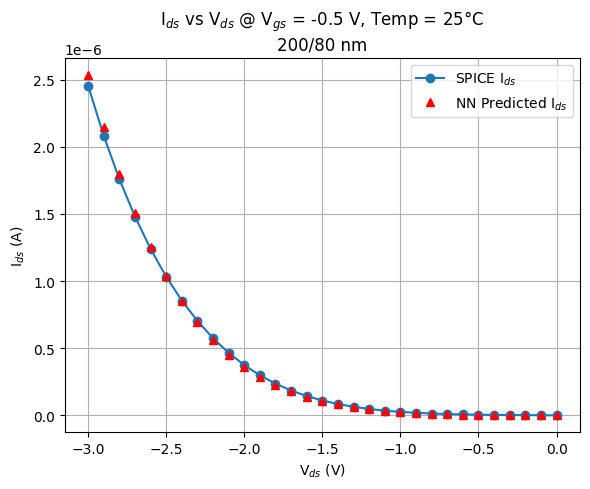

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


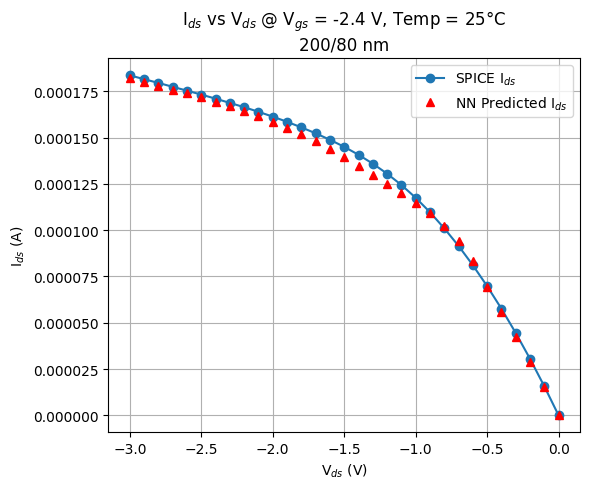

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


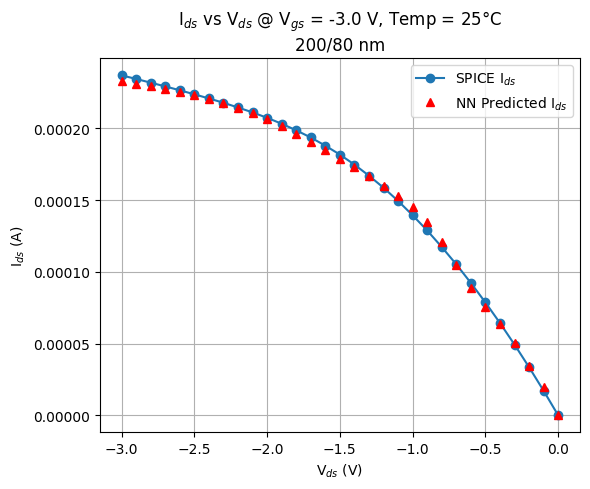

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


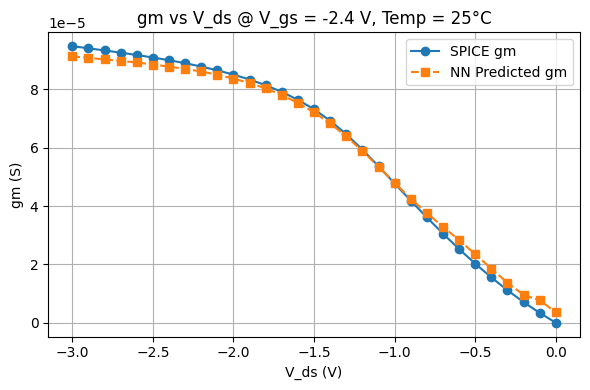

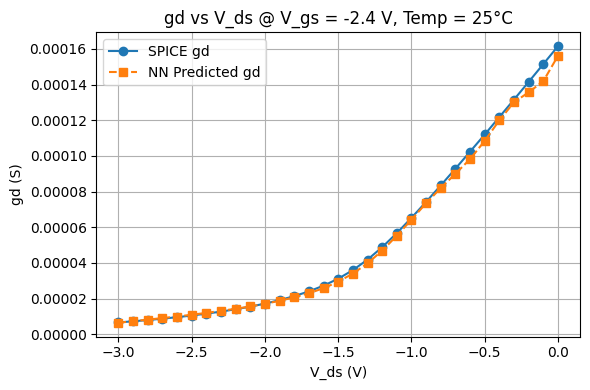

In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set Vgs and temperature for comparison
VGS_TARGET = -2.4
TEMP_TARGET = 25

# Load and filter SPICE data
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
df_filtered = df_spice[mask].sort_values(by="Vds(V)")

if df_filtered.empty:
    print(f"⚠️ No data found for Vgs={VGS_TARGET} V, Temp={TEMP_TARGET}°C")
else:
    # Prepare input
    signature = device_signatures[2]  # Device 1
    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_plot_scaled = scaler.transform(X_plot)

    # Predict with model → outputs: [log10(Id), gm_scaled, gd_scaled]
    y_pred = model.predict(X_plot_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gd_pred_scaled = y_pred[:, 2]

    # Invert standard scaling
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()

    # True gm and gd
    gm_spice = df_filtered["gm"].values
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    # Plot gm
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gm_spice, "o-", label="SPICE gm")
    plt.plot(vds_vals, gm_pred, "s--", label="NN Predicted gm")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gm (S)")
    plt.title(f"gm vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot gd
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gd_spice, "o-", label="SPICE gd")
    plt.plot(vds_vals, gd_pred, "s--", label="NN Predicted gd")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gd (S)")
    plt.title(f"gd vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


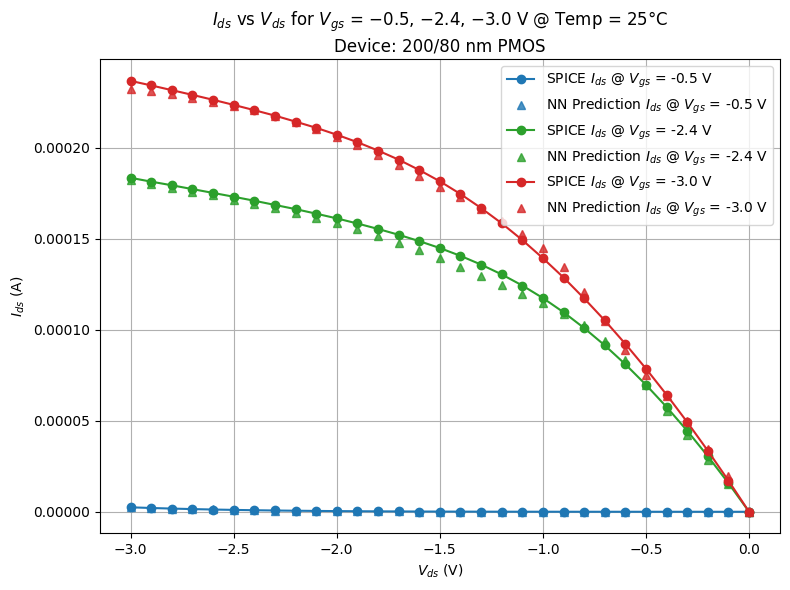

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


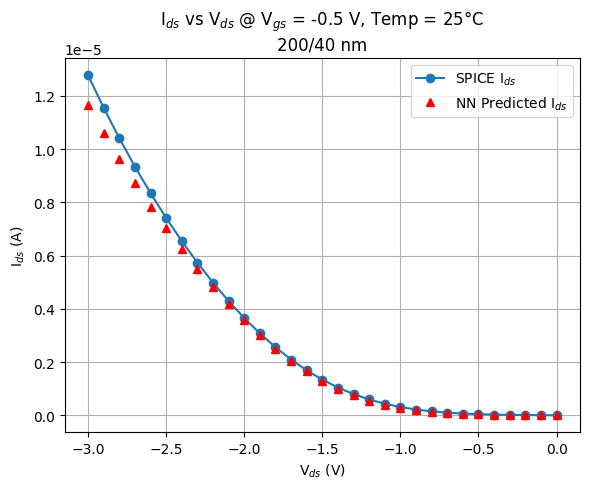

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


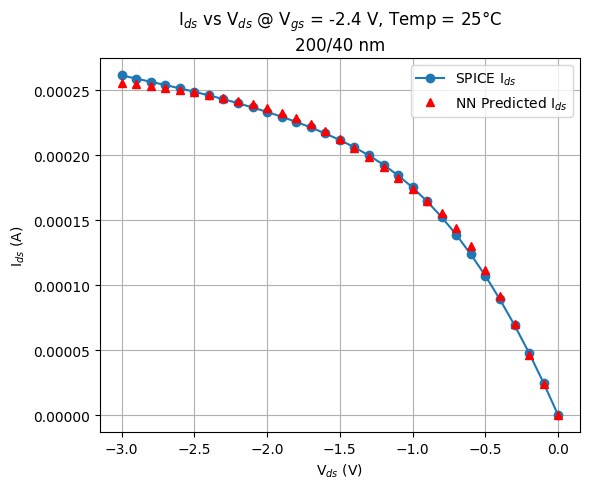

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


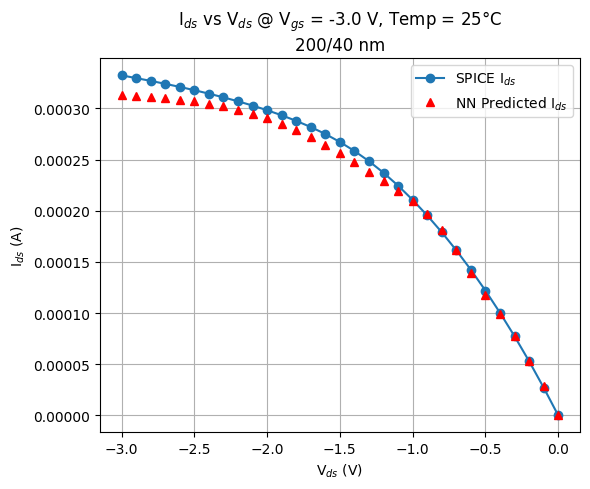

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


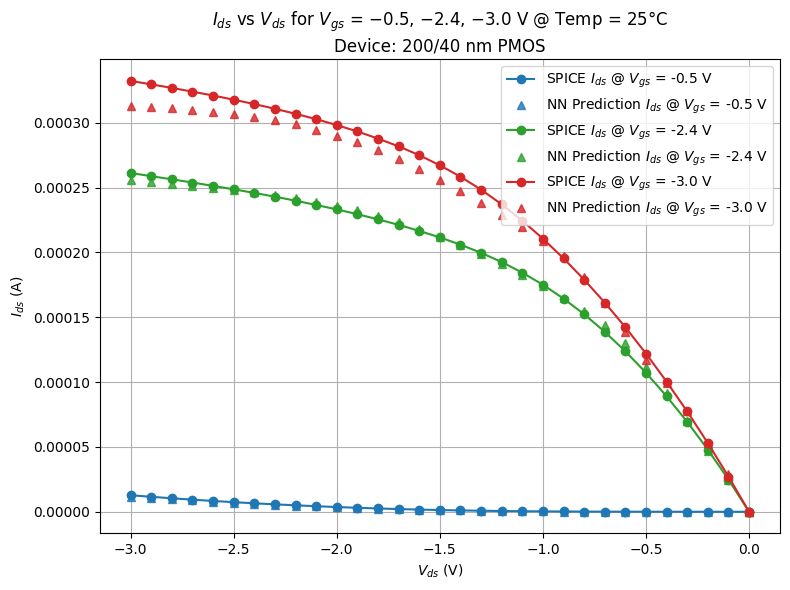

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


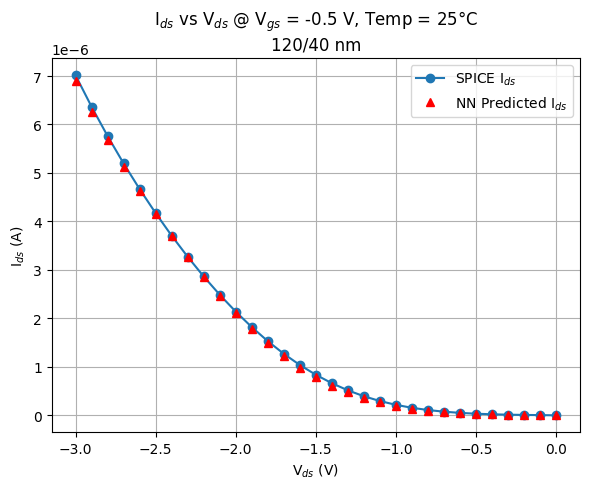

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


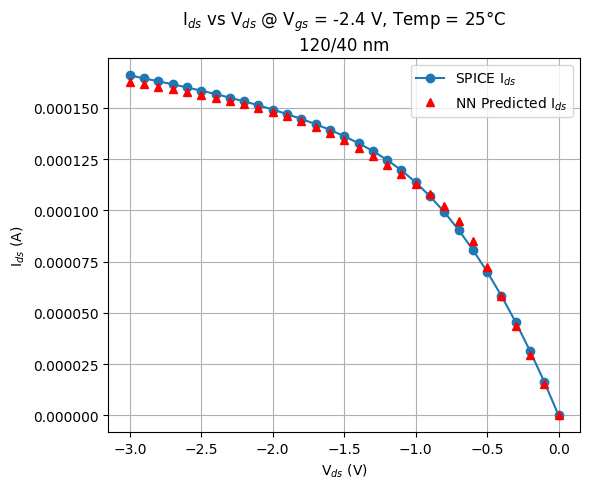

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


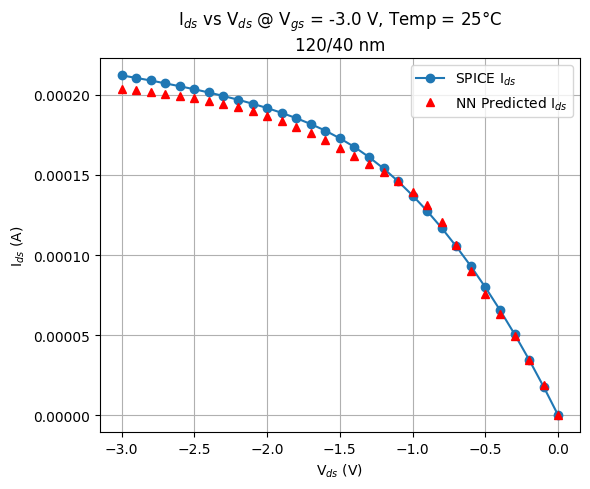

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n120/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


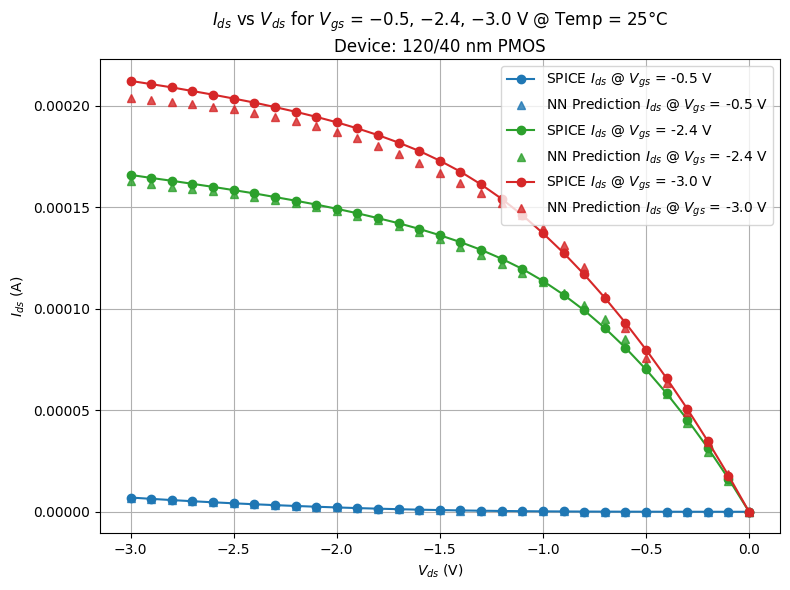

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 120/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


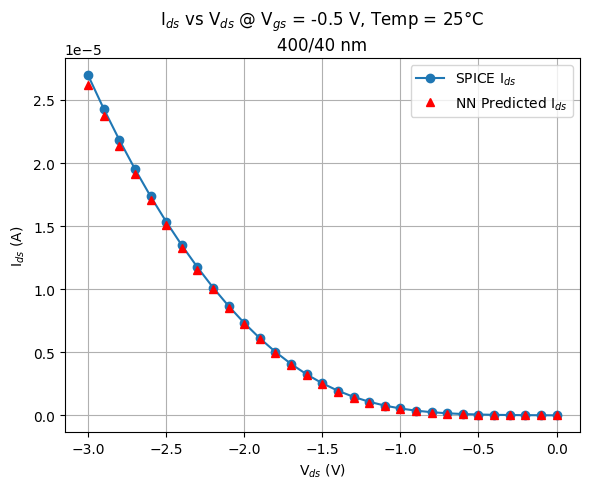

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


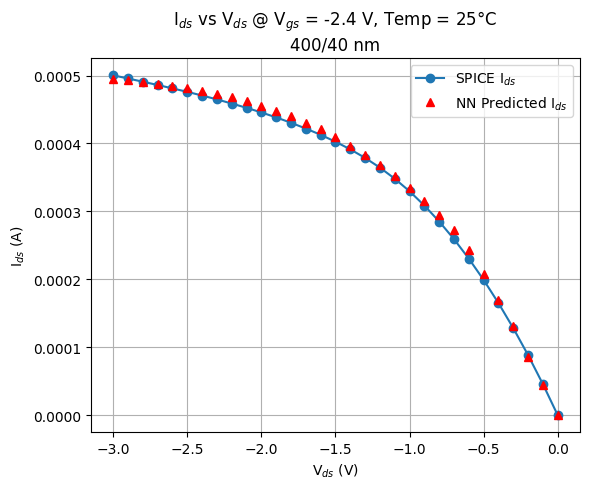

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


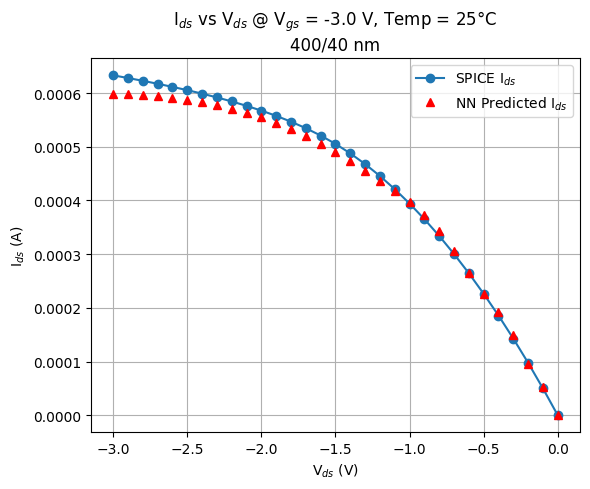

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


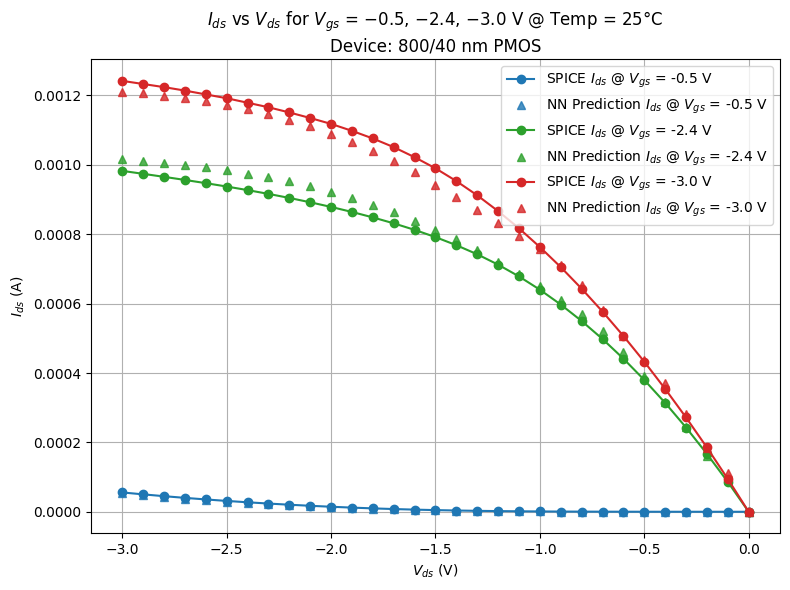

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 800/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


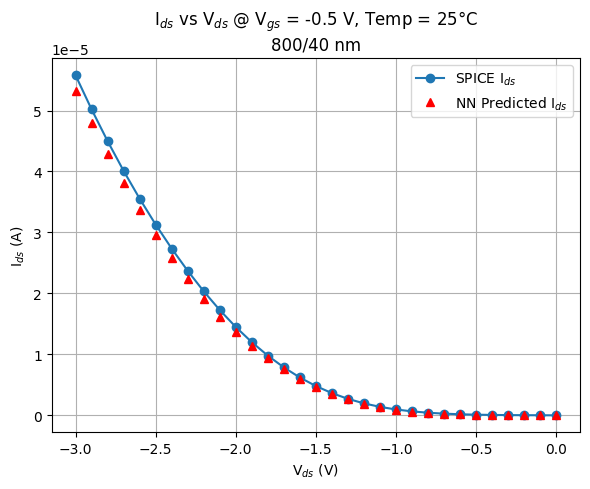

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


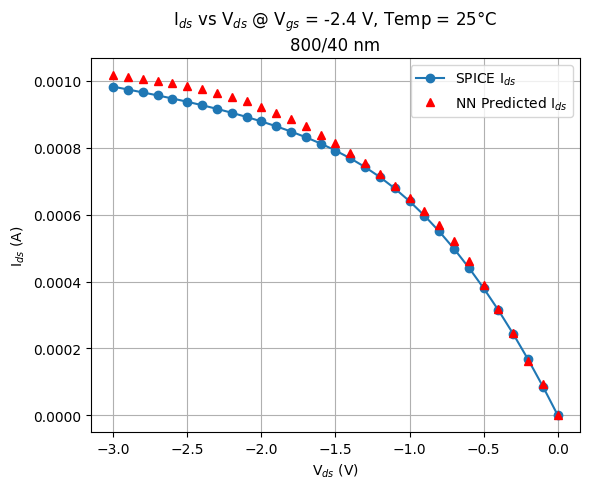

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


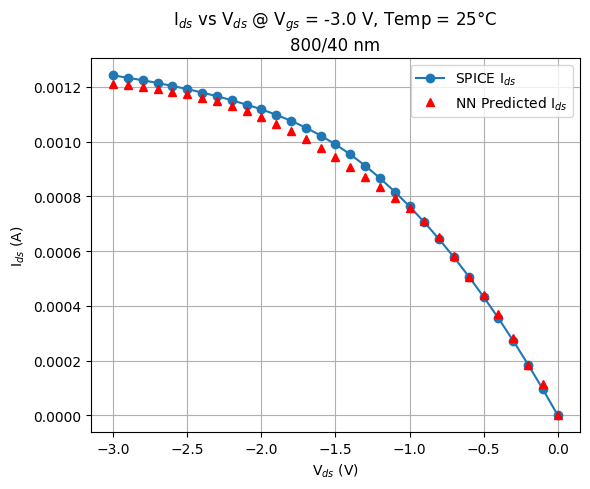

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n800/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


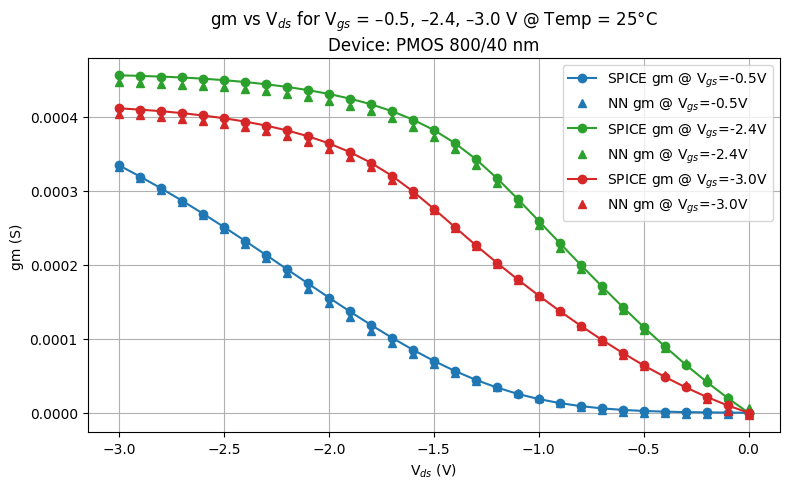

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


<Figure size 800x500 with 0 Axes>

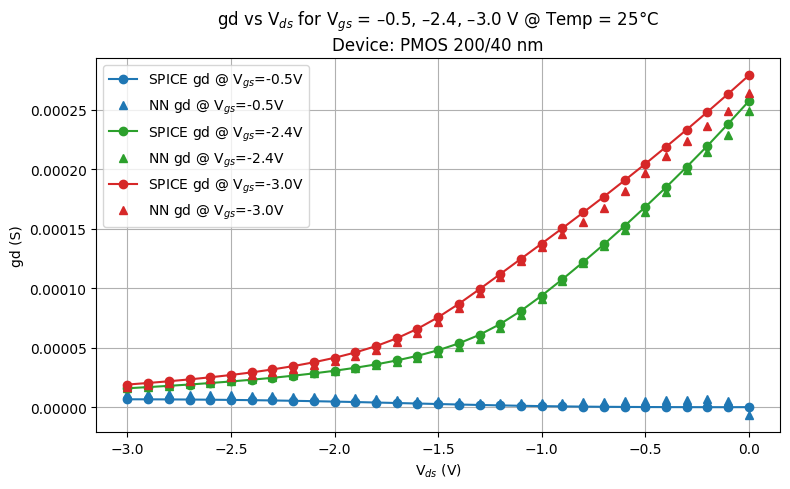

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


<Figure size 800x500 with 0 Axes>

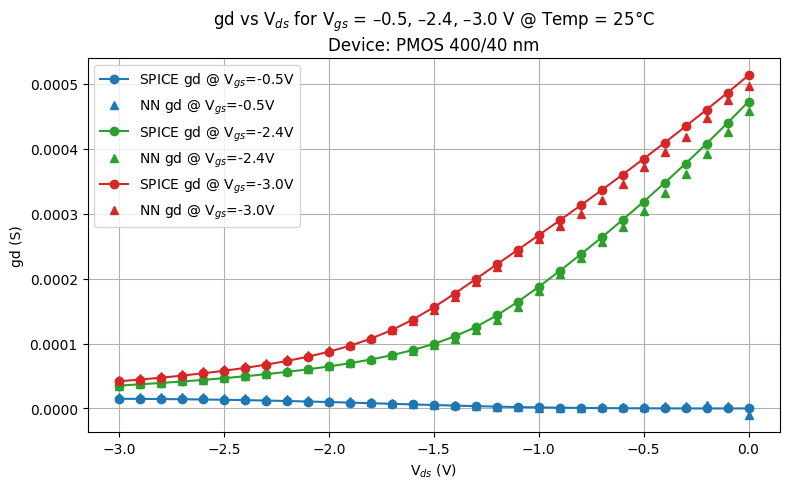

In [60]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


<Figure size 800x500 with 0 Axes>

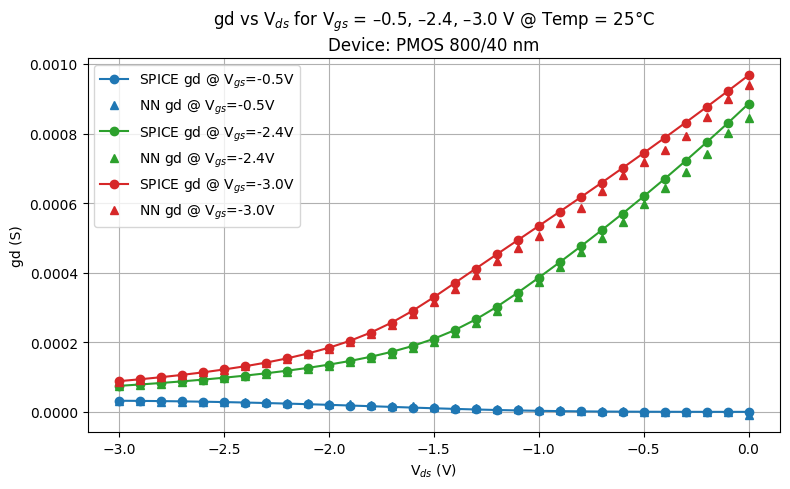

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


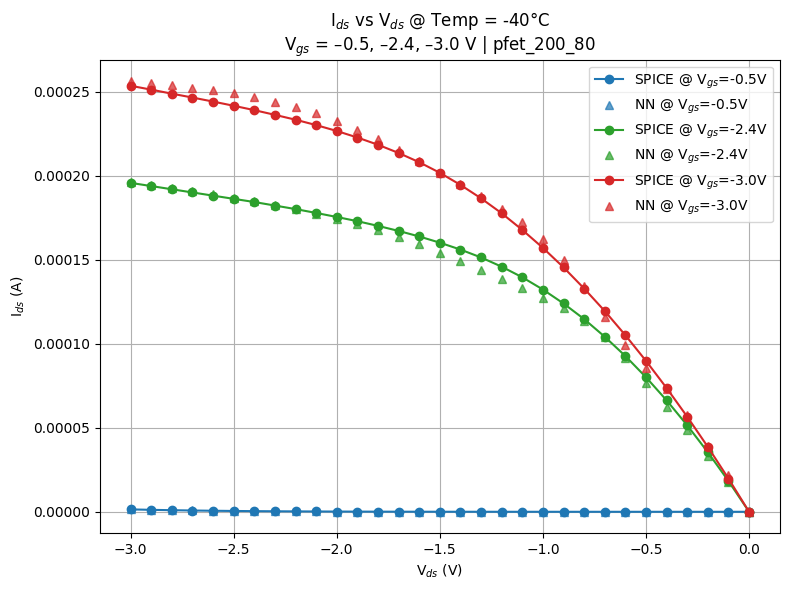

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


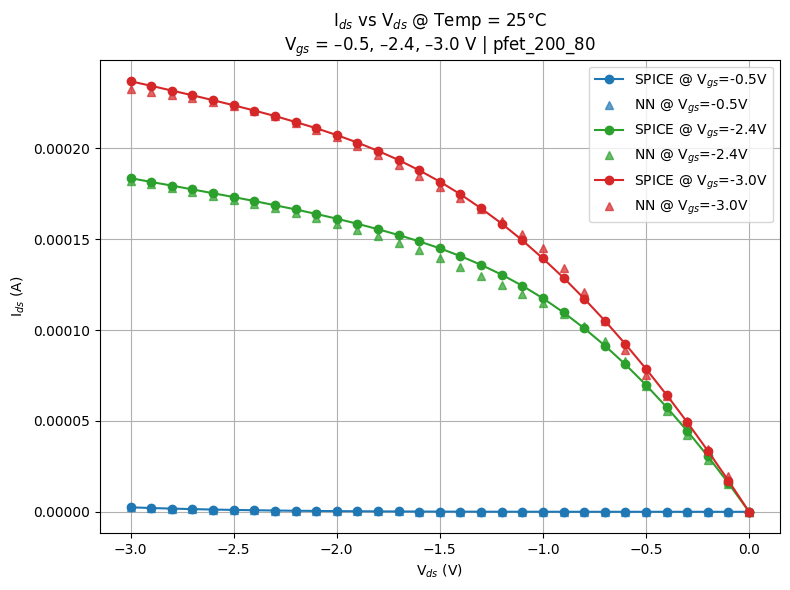

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


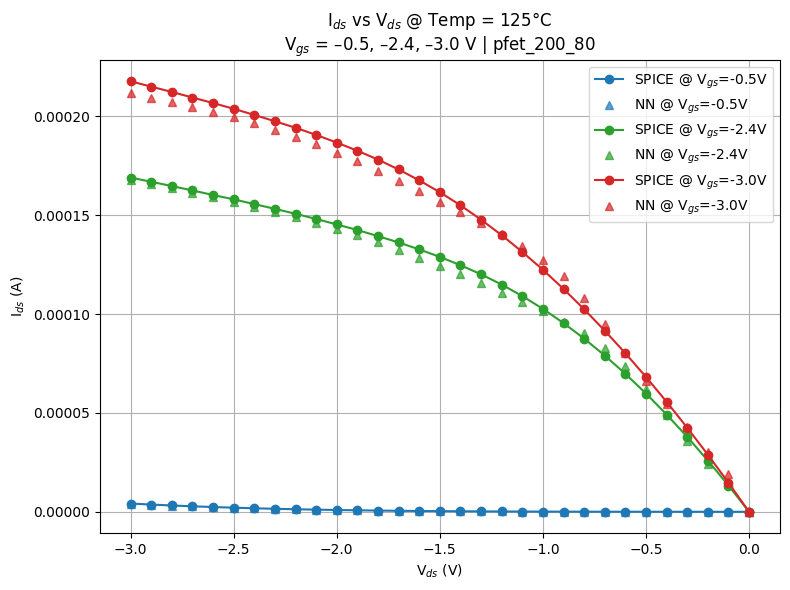

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


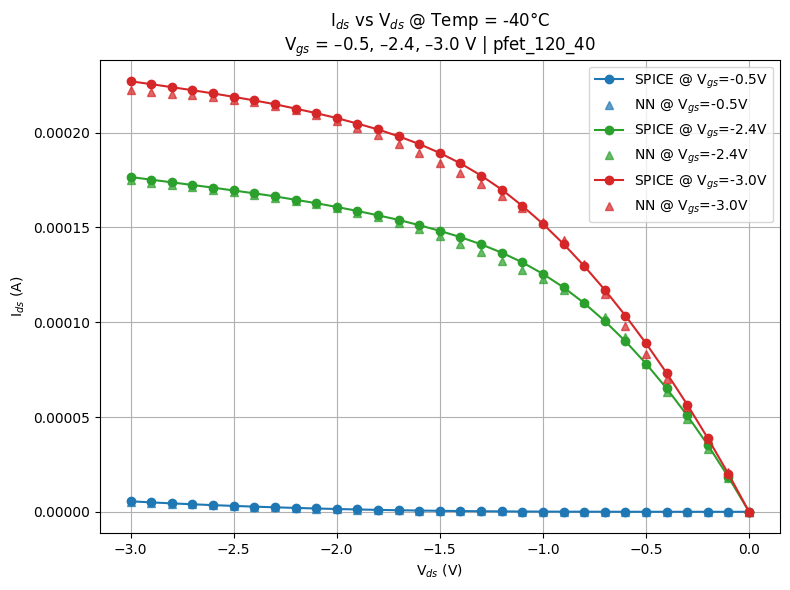

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


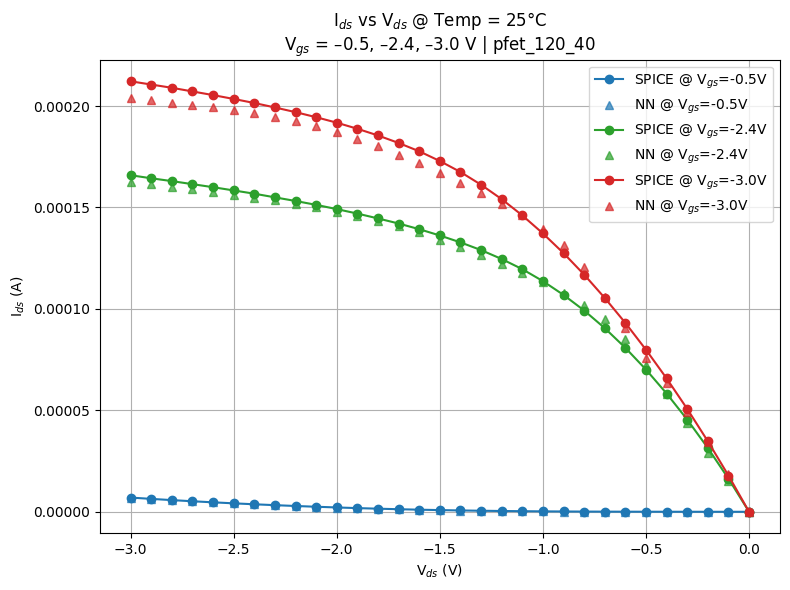

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


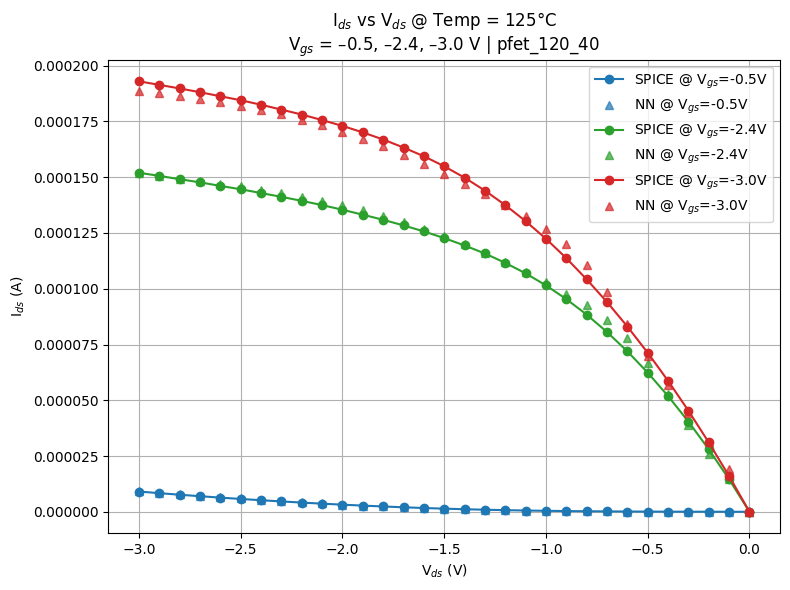

In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 0  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_120_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


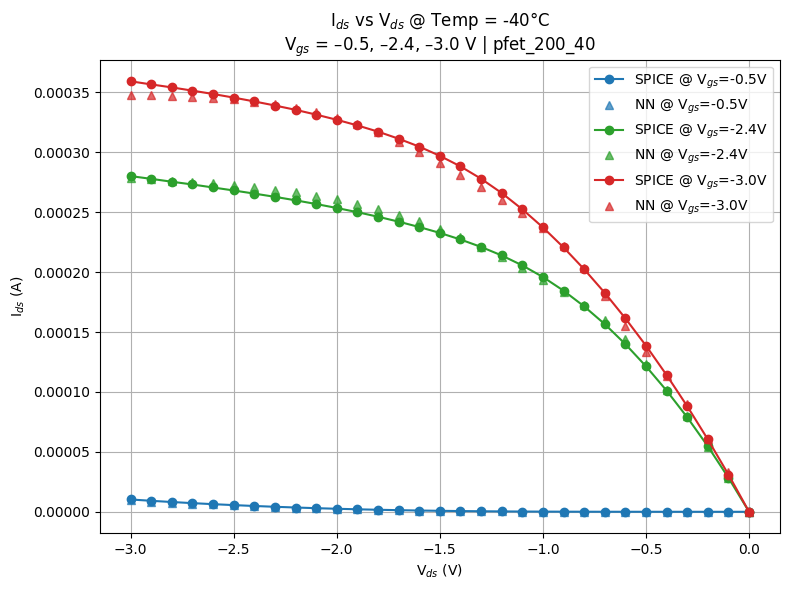

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


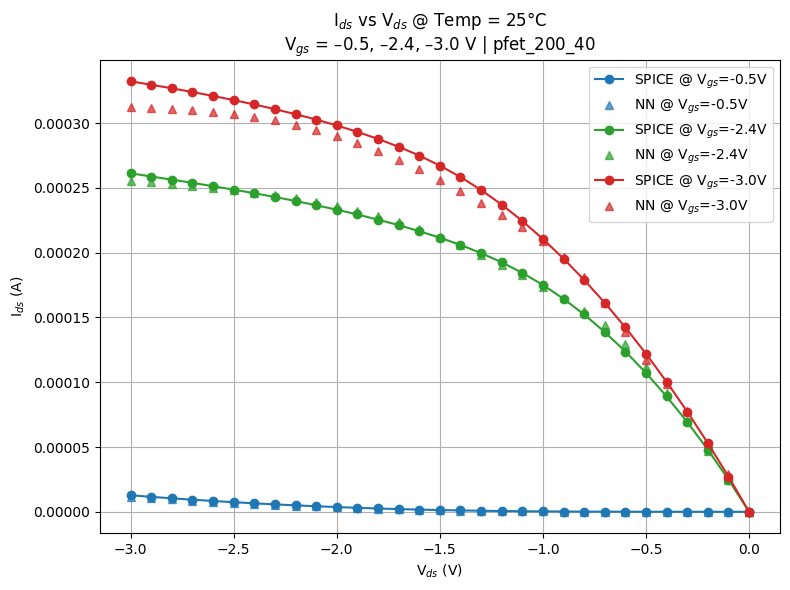

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


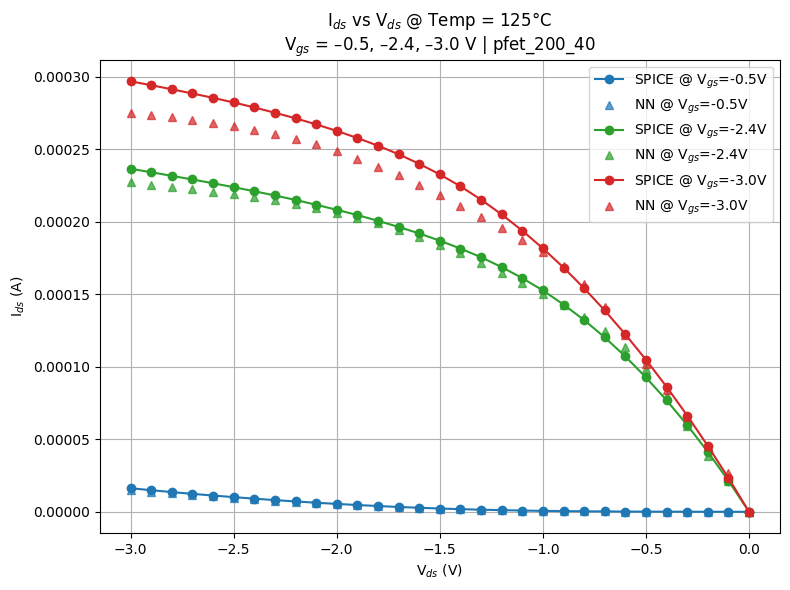

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 1  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


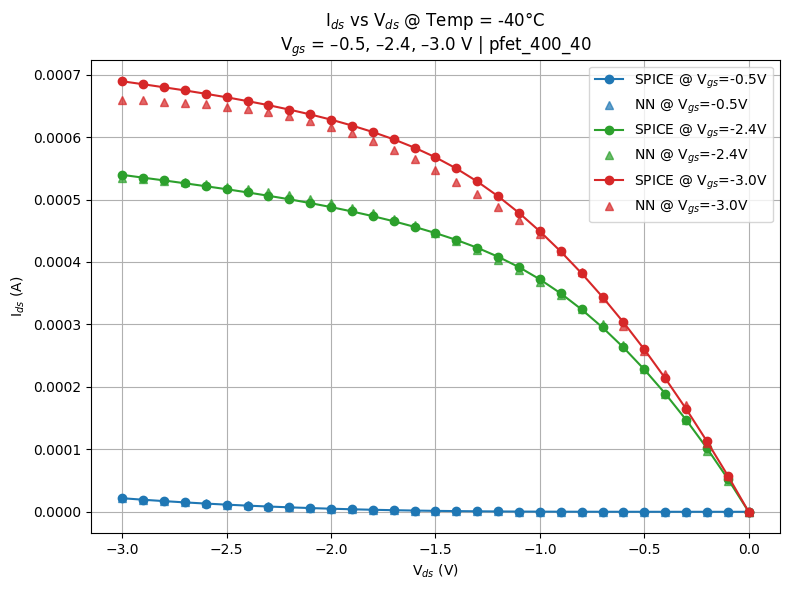

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


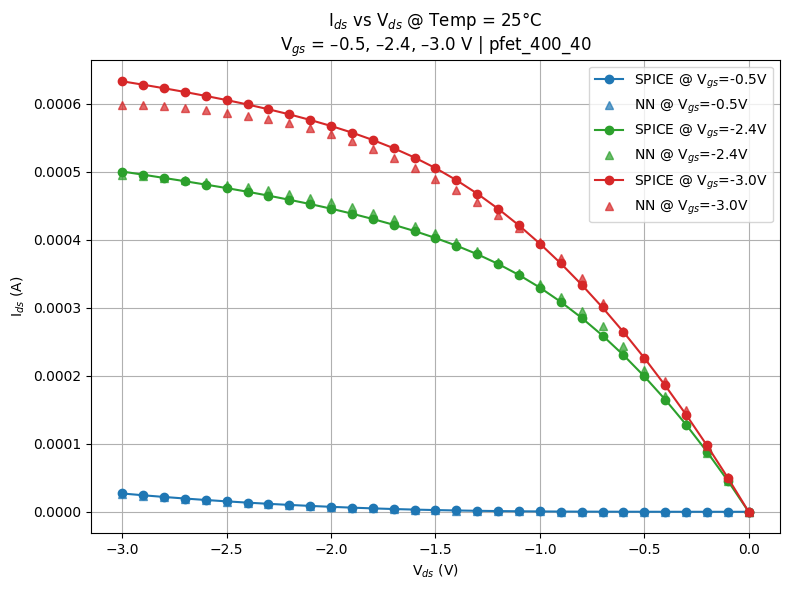

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


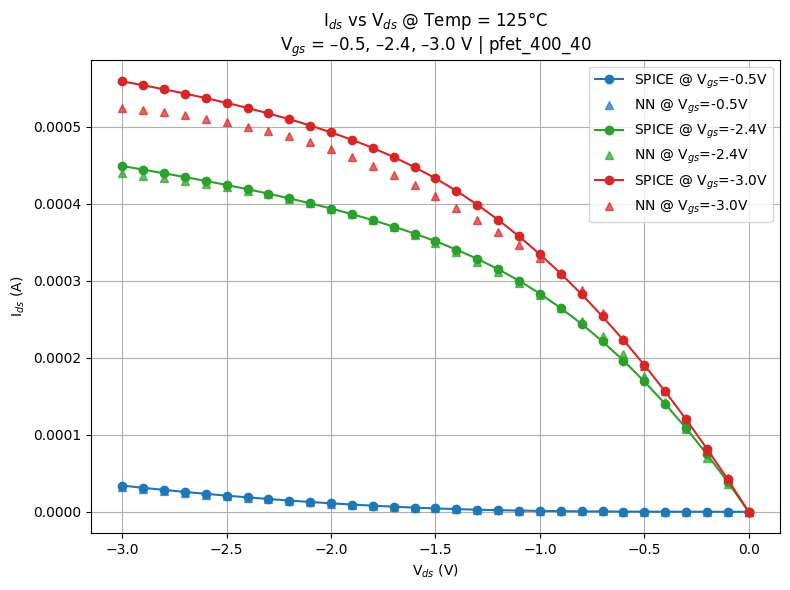

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 3  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_400_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


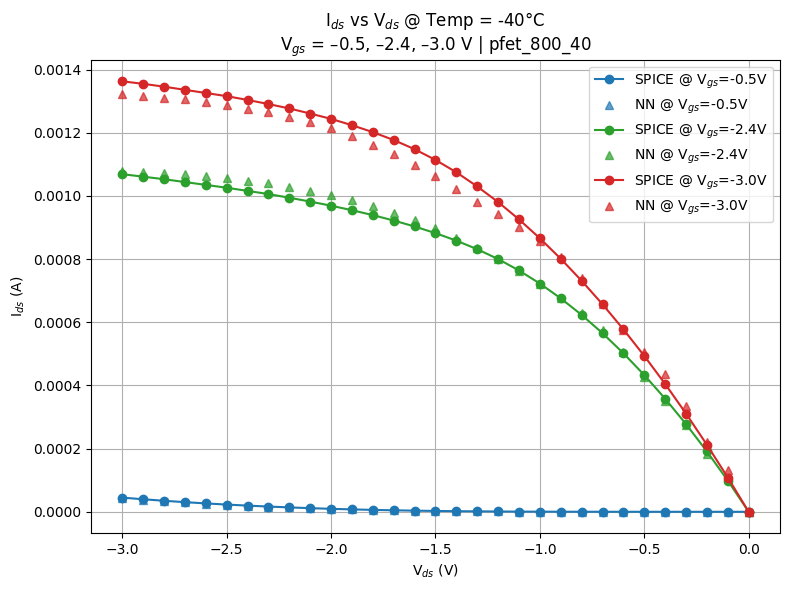

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


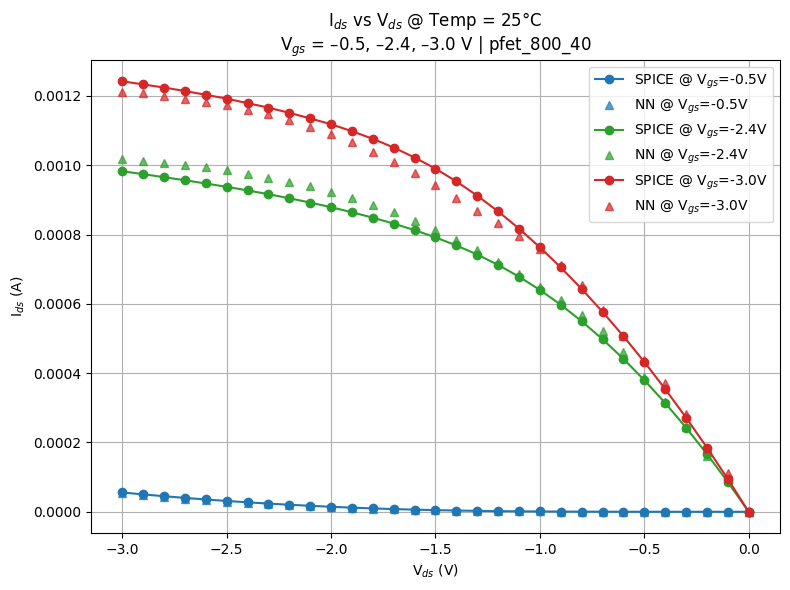

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


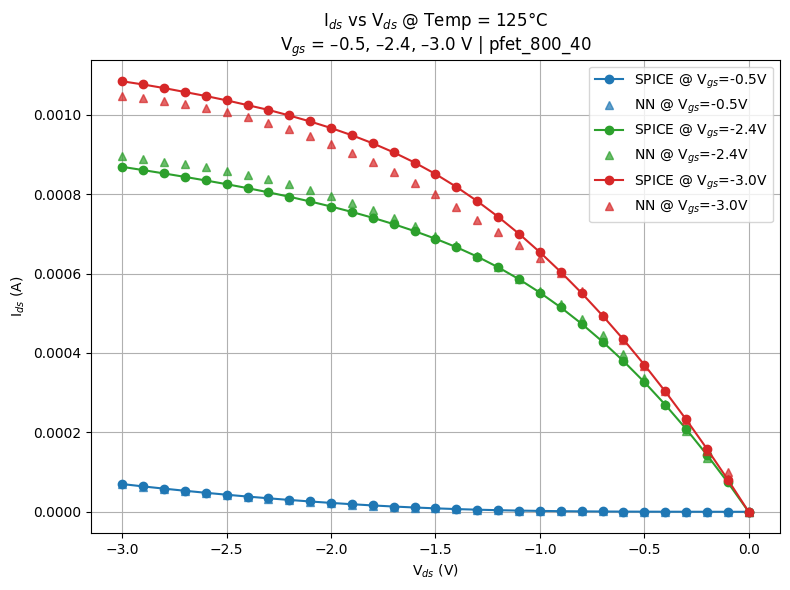

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 4  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_800_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


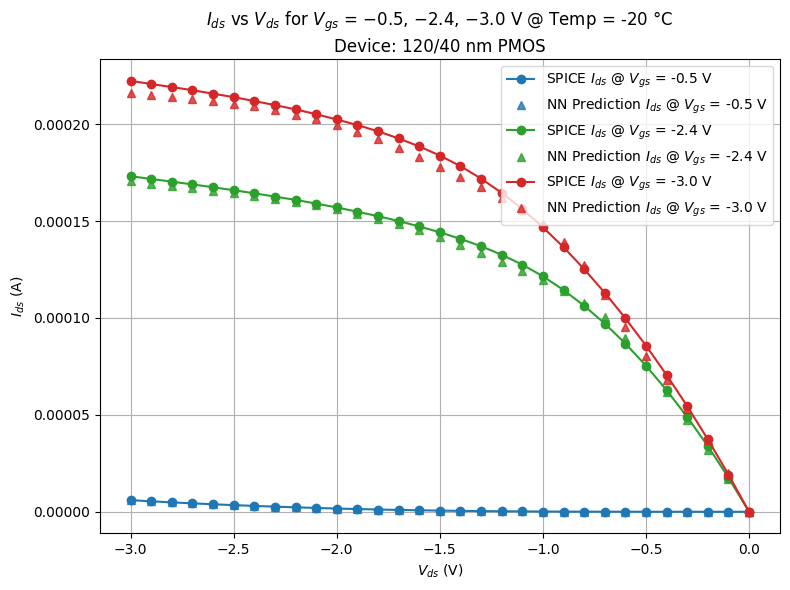

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


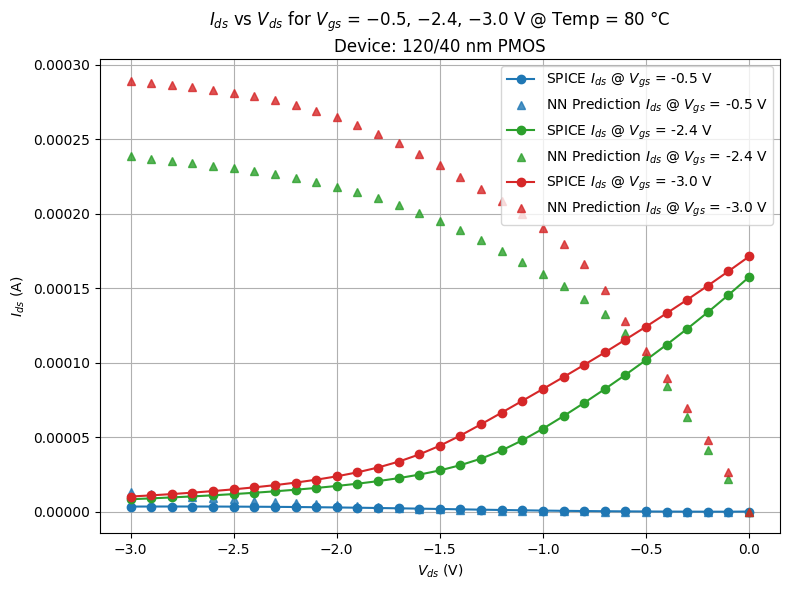

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


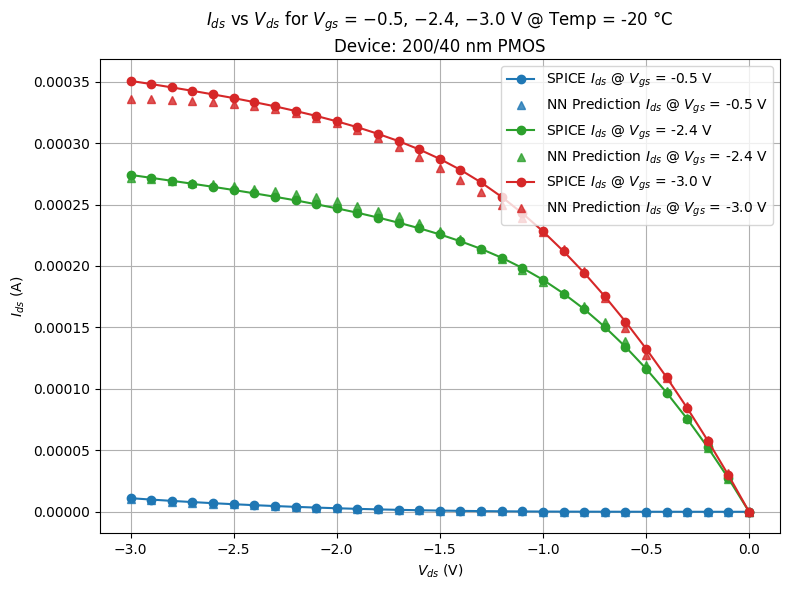

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


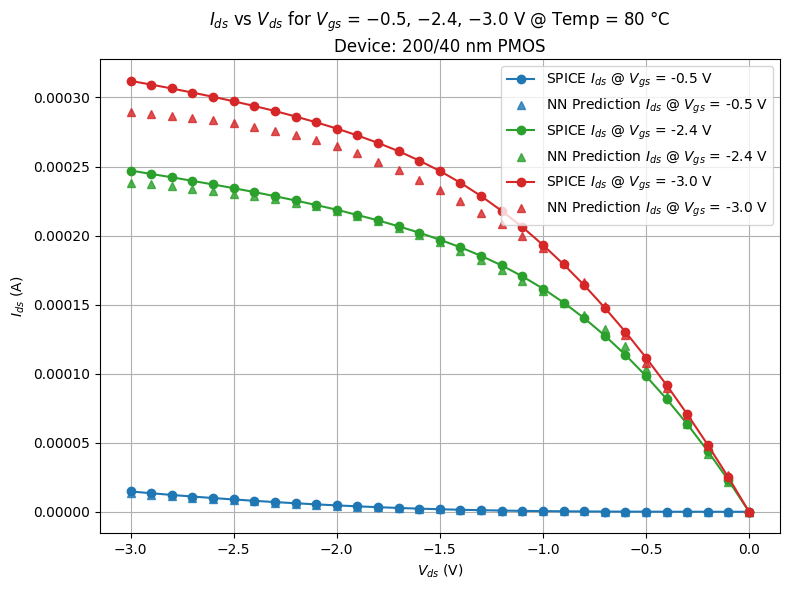

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


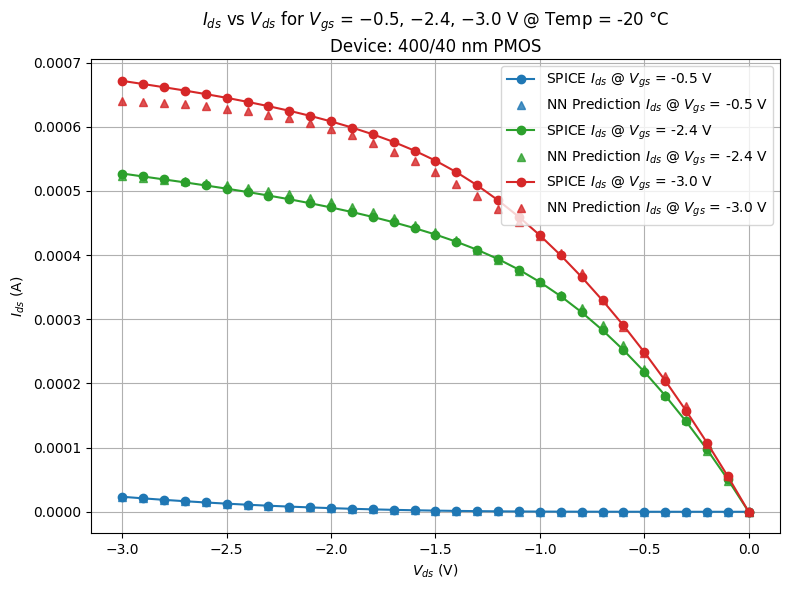

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


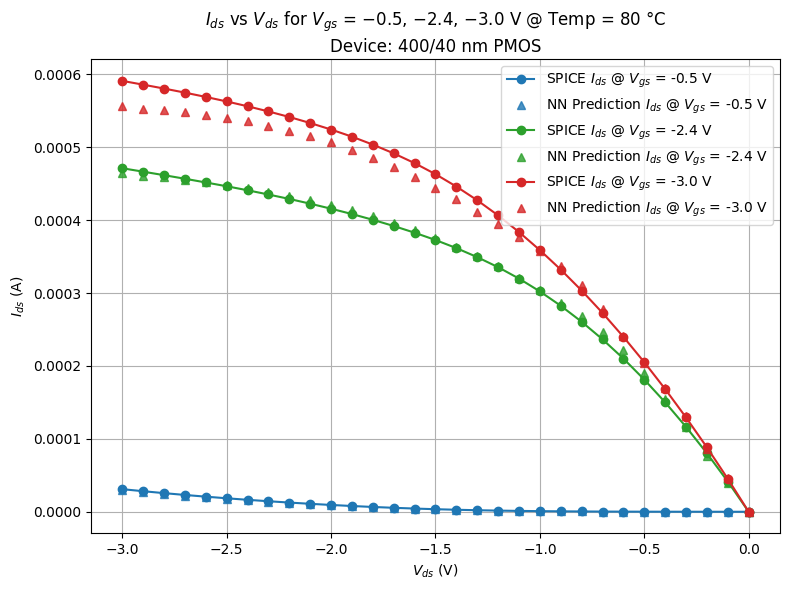

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


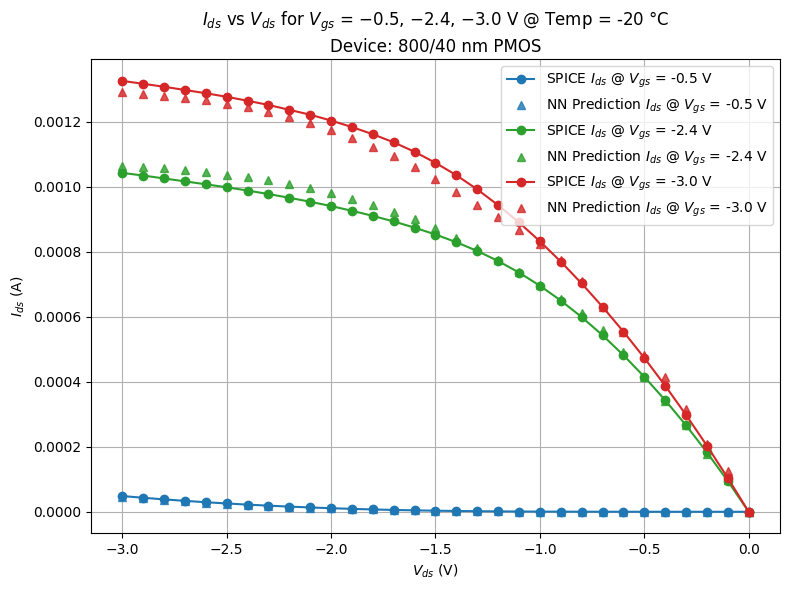

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


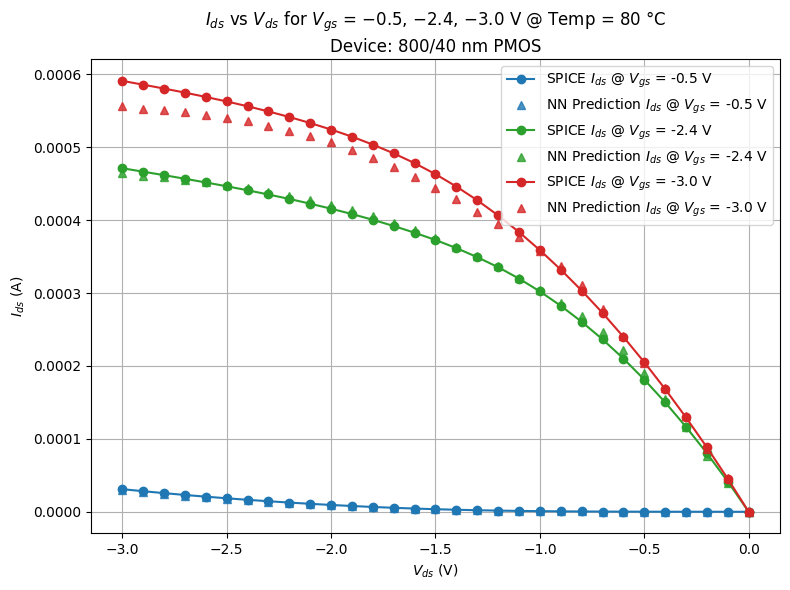

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
